# Evaluation of topic modelling
This notebook aims to give an evaluation of the accuracy with which the topic of bills are identified.
We do this by comparing our results to the topics that are given to bills in the dataset, i.e. bills that have the same topic according to the dataset, should also have the same topic in our results.

In the dataset, each bill has a set of topics and one main topic. 

We will use two metrics for the evaluation, a strict and a loose metric. The strict metric requires the main topic of bills as specified in the dataset to match exactly. The loose metric requires at least $k$ topics to match in the sets of topics to consider two bills as being in the same category.

### Test set for the evaluation (temporary)

In [2]:
import csv
import random 
with open('test_evaluation_data.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter='|')
    for x in range(500):
        topic = random.randint(1, 5)
        true_topic = random.choices([topic, random.randint(1, 5)], weights = [8,2])[0]
        filewriter.writerow([topic, true_topic, 'none'])

### Load LDA & Read results

In [3]:
import csv
import sys
import gensim
from collections import defaultdict, Counter

csv.field_size_limit(sys.maxsize)

131072

In [4]:
# Allow for changes in final format of the CSV file by making the relevant column ids variables
dataset_main_subject_column = 1
dataset_subjects_column = 2
topic_column = 2

results = '112_processed_mallet.csv'

In [5]:
# Create a dictionary of topics found in results with their respective bills
topics = defaultdict(list)

with open(results, newline='') as csvfile:
    csvfile.readline()
    rows = csv.reader(csvfile, delimiter='|')
    for row in rows:
        bill = dict()   
        bill['topic'] = row[topic_column]
        bill['dataset_subjects'] = row[dataset_subjects_column]
        bill['dataset_main_subject'] = row[dataset_main_subject_column]
        
        topics[bill['topic']].append(bill)

We now go over each identified topic and evaluate wether its bills are in fact have the same subject (according to the dataset)

### Strict metric

Find out how many 'actual topics' each identified topic contains

In [6]:
true_topics_per_topic = dict()
for topic, bills in topics.items():
    true_topics = Counter()
    for bill in bills:
        true_topic = bill['dataset_main_subject']
        true_topics[true_topic] += 1
    true_topics_per_topic[topic] = true_topics

In [7]:
bill_counts = []
frequencies = []

for topic, true_topics in true_topics_per_topic.items():
    n_bills = sum(true_topics.values())
    print("Topic:", topic)
    print("# bills:", n_bills)
    print("# real topics:", len(true_topics))
    print("Most common real topic frequency:", true_topics.most_common(1)[0][1] / n_bills)
    print("---------------------------------------")
    bill_counts.append(n_bills)
    frequencies.append(true_topics.most_common(1)[0][1] / n_bills)


Topic: 1
# bills: 198
# real topics: 26
Most common real topic frequency: 0.35858585858585856
---------------------------------------
Topic: 0
# bills: 2101
# real topics: 8
Most common real topic frequency: 0.99428843407901
---------------------------------------
Topic: 4
# bills: 238
# real topics: 13
Most common real topic frequency: 0.773109243697479
---------------------------------------
Topic: 26
# bills: 232
# real topics: 17
Most common real topic frequency: 0.5905172413793104
---------------------------------------
Topic: 10
# bills: 222
# real topics: 24
Most common real topic frequency: 0.32882882882882886
---------------------------------------
Topic: 9
# bills: 220
# real topics: 18
Most common real topic frequency: 0.5
---------------------------------------
Topic: 18
# bills: 671
# real topics: 22
Most common real topic frequency: 0.6631892697466468
---------------------------------------
Topic: 22
# bills: 313
# real topics: 18
Most common real topic frequency: 0.60702

In [125]:
true_topics_per_topic['24']

Counter({'Government operations and politics': 215,
         'Congress': 7,
         'Crime and law enforcement': 6,
         'Armed forces and national security': 5,
         'Agriculture and food': 4,
         'Finance and financial sector': 4,
         'Commerce': 4,
         'Economics and public finance': 2,
         'Water resources development': 3,
         'Emergency management': 7,
         'Transportation and public works': 1,
         'Education': 2,
         'Law': 1,
         'Energy': 1,
         'Public lands and natural resources': 2,
         'Social welfare': 1,
         'Housing and community development': 1})

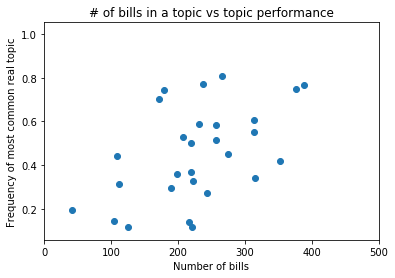

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.xlabel("Number of bills")
plt.ylabel("Frequency of most common real topic")


plt.scatter(bill_counts, frequencies, label = "Topics")
plt.title("# of bills in a topic vs topic performance")
plt.xlim(left=0, right=500)
plt.show()